Before we get the data and start exploring it, let's download all the dependencies that we will need.


In [6]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files


from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import seaborn as sns


print('Libraries imported.')

Libraries imported.


<a id='item1'></a>


The Coursera course materials inculded a json file with lat/long coordinates for each of New York's boroughs and neighborhoods.

In [2]:
!wget -q -O 'newyork_data.json' https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs/newyork_data.json
print('Data downloaded!')

Data downloaded!


#### Load and explore the data


Next, let's load the data into a pandas dataframe.


In [7]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [11]:
neighborhoods_data = newyork_data['features']

In [9]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

In [12]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

Quickly examine the resulting dataframe.


In [8]:
neighborhoods.head()

Borough Neighborhood   Latitude  Longitude
0   Bronx    Wakefield  40.894705 -73.847201
1   Bronx   Co-op City  40.874294 -73.829939
2   Bronx  Eastchester  40.887556 -73.827806
3   Bronx    Fieldston  40.895437 -73.905643
4   Bronx    Riverdale  40.890834 -73.912585

And make sure that the dataset has all 5 boroughs and 306 neighborhoods.


In [7]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.


#### Define Foursquare Credentials and Version


In [58]:
# CLIENT_ID = 'your-client-ID' # your Foursquare ID
# CLIENT_SECRET = 'your-client-secret' # your Foursquare Secret
# VERSION = '20180605' # Foursquare API version


CLIENT_ID = 'I3X0HQQPFPWIVETMK4HD2XQCDSOUUB2HKKJ3WJ4YFHB3EGID' # your Foursquare ID
CLIENT_SECRET = 'RX0LHE0KU34RA2FZMZ3NCSYNEIR1TKHZBRFIOIECXXH0A0GR' # your Foursquare Secret
ACCESS_TOKEN = '3Y5G425AO1XQL0MLSCTH35QREU0UIHTTMQC20ZQPY1BOKNVC' # your FourSquare Access Token
VERSION = '20180604'
LIMIT = 100 # A default Foursquare API limit value

print('Your credentials:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentials:
CLIENT_ID: I3X0HQQPFPWIVETMK4HD2XQCDSOUUB2HKKJ3WJ4YFHB3EGID
CLIENT_SECRET:RX0LHE0KU34RA2FZMZ3NCSYNEIR1TKHZBRFIOIECXXH0A0GR


From the Foursquare lab in the previous module, we know that all the information is in the _items_ key. Before we proceed, let's borrow the **get_category_type** function from the Foursquare lab.


In [18]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

#### Let's create a function to collect and clean up information for venues in all the neighborhoods in New York


In [20]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Now write the code to run the above function on each neighborhood and create a new dataframe called _all_venues_.


In [60]:
all_venues = getNearbyVenues(names=neighborhoods['Neighborhood'],
                            latitudes=neighborhoods['Latitude'],
                            longitudes=neighborhoods['Longitude'])

Wakefield
Co-op City
Eastchester
Fieldston
Riverdale
Kingsbridge
Marble Hill
Woodlawn
Norwood
Williamsbridge
Baychester
Pelham Parkway
City Island
Bedford Park
University Heights
Morris Heights
Fordham
East Tremont
West Farms
High  Bridge
Melrose
Mott Haven
Port Morris
Longwood
Hunts Point
Morrisania
Soundview
Clason Point
Throgs Neck
Country Club
Parkchester
Westchester Square
Van Nest
Morris Park
Belmont
Spuyten Duyvil
North Riverdale
Pelham Bay
Schuylerville
Edgewater Park
Castle Hill
Olinville
Pelham Gardens
Concourse
Unionport
Edenwald
Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker

#### Let's check the size of the resulting dataframe


In [26]:
print(all_venues.shape)
print(all_venues.head())

(10039, 7)
  Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0    Wakefield              40.894705              -73.847201   
1    Wakefield              40.894705              -73.847201   
2    Wakefield              40.894705              -73.847201   
3    Wakefield              40.894705              -73.847201   
4    Wakefield              40.894705              -73.847201   

              Venue  Venue Latitude  Venue Longitude  Venue Category  
0  Lollipops Gelato       40.894123       -73.845892    Dessert Shop  
1          Rite Aid       40.896649       -73.844846        Pharmacy  
2         Walgreens       40.896528       -73.844700        Pharmacy  
3  Carvel Ice Cream       40.890487       -73.848568  Ice Cream Shop  
4           Dunkin'       40.890459       -73.849089      Donut Shop  


There are 10039 venues, so hopefully breaking this out by neighborhood will allow us to generate enough features to cluster the neighboorhoods descriptively.

Let's check how many venues were returned for each neighborhood


In [27]:
all_venues.groupby('Neighborhood').count()

Neighborhood Latitude  Neighborhood Longitude  \
Neighborhood                                                               
Allerton                                      25                      25   
Annadale                                       9                       9   
Arden Heights                                  4                       4   
Arlington                                      5                       5   
Arrochar                                      22                      22   
Arverne                                       19                      19   
Astoria                                       96                      96   
Astoria Heights                               14                      14   
Auburndale                                    18                      18   
Bath Beach                                    50                      50   
Battery Park City                             73                      73   
Bay Ridge                                     77                      77   
Bay Terrace                                   51                      51   
Baychester                                    18                      18   
Bayside                                       77                      77   
Bayswater                                      1                       1   
Bedford Park                                  33                      33   
Bedford Stuyvesant                            29                      29   
Beechhurst                                    13                      13   
Bellaire                                      15                      15   
Belle Harbor                                  18                      18   
Bellerose                                     22                      22   
Belmont                                       97                      97   
Bensonhurst                                   35                      35   
Bergen Beach                                   6                       6   
Blissville                                    17                      17   
Bloomfield                                     4                       4   
Boerum Hill                                   93                      93   
Borough Park                                  24                      24   
Breezy Point                                   6                       6   
Briarwood                                      8                       8   
Brighton Beach                                43                      43   
Broad Channel                                  6                       6   
Broadway Junction                             16                      16   
Bronxdale                                     12                      12   
Brooklyn Heights                             100                     100   
Brookville                                     2                       2   
Brownsville                                   14                      14   
Bulls Head                                    40                      40   
Bushwick                                      69                      69   
Butler Manor                                   6                       6   
Cambria Heights                               12                      12   
Canarsie                                       4                       4   
Carnegie Hill                                 88                      88   
Carroll Gardens                              100                     100   
Castle Hill                                    7                       7   
Castleton Corners                             17                      17   
Central Harlem                                46                      46   
Charleston                                    25                      25   
Chelsea                                      106                     106   
Chinatown                                    100                     100   

#### Let's find out how many unique categories can be curated from all the returned venues


In [28]:
print('There are {} unique categories.'.format(len(all_venues['Venue Category'].unique())))

There are 433 unique categories.


<a id='item3'></a>


## 3. Analyze Each Neighborhood


In [29]:
# one hot encoding
hoods_onehot = pd.get_dummies(all_venues[['Venue Category']], prefix="", prefix_sep="")

hoods_onehot = hoods_onehot.drop(['Neighborhood'], axis=1)
# add neighborhood column back to dataframe
hoods_onehot['Neighborhood'] = all_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [hoods_onehot.columns[-1]] + list(hoods_onehot.columns[:-1])
hoods_onehot = hoods_onehot[fixed_columns]

hoods_onehot.head()

Neighborhood  Accessories Store  Adult Boutique  Afghan Restaurant  \
0    Wakefield                  0               0                  0   
1    Wakefield                  0               0                  0   
2    Wakefield                  0               0                  0   
3    Wakefield                  0               0                  0   
4    Wakefield                  0               0                  0   

   African Restaurant  American Restaurant  Antique Shop  Arcade  \
0                   0                    0             0       0   
1                   0                    0             0       0   
2                   0                    0             0       0   
3                   0                    0             0       0   
4                   0                    0             0       0   

   Arepa Restaurant  Argentinian Restaurant  Art Gallery  Art Museum  \
0                 0                       0            0           0   
1                 0                       0            0           0   
2                 0                       0            0           0   
3                 0                       0            0           0   
4                 0                       0            0           0   

   Arts & Crafts Store  Arts & Entertainment  Asian Restaurant  \
0                    0                     0                 0   
1                    0                     0                 0   
2                    0                     0                 0   
3                    0                     0                 0   
4                    0                     0                 0   

   Athletics & Sports  Auditorium  Australian Restaurant  Austrian Restaurant  \
0                   0           0                      0                    0   
1                   0           0                      0                    0   
2                   0           0                      0                    0   
3                   0           0                      0                    0   
4                   0           0                      0                    0   

   Auto Workshop  Automotive Shop  BBQ Joint  Baby Store  Bagel Shop  Bakery  \
0              0                0          0           0           0       0   
1              0                0          0           0           0       0   
2              0                0          0           0           0       0   
3              0                0          0           0           0       0   
4              0                0          0           0           0       0   

   Bank  Bar  Baseball Field  Baseball Stadium  Basketball Court  Bath House  \
0     0    0               0                 0                 0           0   
1     0    0               0                 0                 0           0   
2     0    0               0                 0                 0           0   
3     0    0               0                 0                 0           0   
4     0    0               0                 0                 0           0   

   Beach  Beach Bar  Bed & Breakfast  Beer Bar  Beer Garden  Beer Store  \
0      0          0                0         0            0           0   
1      0          0                0         0            0           0   
2      0          0                0         0            0           0   
3      0          0                0         0            0           0   
4      0          0                0         0            0           0   

   Big Box Store  Bike Rental / Bike Share  Bike Shop  Bike Trail  Bistro  \
0              0                         0          0           0       0   
1              0                         0          0           0       0   
2              0                         0          0           0       0   
3              0                         0          0           0       0   
4              0                         0   

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category


In [32]:
hoods_grouped = hoods_onehot.groupby('Neighborhood').mean().reset_index()
hoods_grouped

Neighborhood  Accessories Store  Adult Boutique  \
0                     Allerton           0.000000        0.000000   
1                     Annadale           0.000000        0.000000   
2                Arden Heights           0.000000        0.000000   
3                    Arlington           0.000000        0.000000   
4                     Arrochar           0.000000        0.000000   
5                      Arverne           0.000000        0.000000   
6                      Astoria           0.000000        0.000000   
7              Astoria Heights           0.000000        0.000000   
8                   Auburndale           0.000000        0.000000   
9                   Bath Beach           0.000000        0.000000   
10           Battery Park City           0.000000        0.000000   
11                   Bay Ridge           0.000000        0.000000   
12                 Bay Terrace           0.019608        0.000000   
13                  Baychester           0.000000        0.000000   
14                     Bayside           0.000000        0.000000   
15                   Bayswater           0.000000        0.000000   
16                Bedford Park           0.000000        0.000000   
17          Bedford Stuyvesant           0.000000        0.000000   
18                  Beechhurst           0.000000        0.000000   
19                    Bellaire           0.000000        0.000000   
20                Belle Harbor           0.000000        0.000000   
21                   Bellerose           0.000000        0.000000   
22                     Belmont           0.000000        0.000000   
23                 Bensonhurst           0.000000        0.000000   
24                Bergen Beach           0.000000        0.000000   
25                  Blissville           0.000000        0.000000   
26                  Bloomfield           0.000000        0.000000   
27                 Boerum Hill           0.000000        0.000000   
28                Borough Park           0.000000        0.000000   
29                Breezy Point           0.000000        0.000000   
30                   Briarwood           0.000000        0.000000   
31              Brighton Beach           0.000000        0.000000   
32               Broad Channel           0.000000        0.000000   
33           Broadway Junction           0.000000        0.000000   
34                   Bronxdale           0.000000        0.000000   
35            Brooklyn Heights           0.000000        0.000000   
36                  Brookville           0.000000        0.000000   
37                 Brownsville           0.000000        0.000000   
38                  Bulls Head           0.000000        0.000000   
39                    Bushwick           0.000000        0.000000   
40                Butler Manor           0.000000        0.000000   
41             Cambria Heights           0.000000        0.000000   
42                    Canarsie           0.000000        0.000000   
43               Carnegie Hill           0.000000        0.000000   
44             Carroll Gardens           0.000000        0.000000   
45                 Castle Hill           0.000000        0.000000   
46           Castleton Corners           0.000000        0.000000   
47              Central Harlem           0.000000        0.000000   
48                  Charleston           0.000000        0.000000   
49                     Chelsea           0.000000        0.000000   
50                   Chinatown           0.000000        0.000000   
51                 City Island           0.000000        0.000000   
52                   City Line           0.000000        0.000000   
53                Civic Center           0.000000        0.000000   
54           Claremont Village           0.000000        0.000000   
55                Clason Point           0.000000        0.000000   
56                     Clifton           0.000000        0.000000   
57              

#### Let's confirm the new size

In [33]:
hoods_grouped.shape

(302, 433)

#### Let's split the data into two dataframes based on whether or not the neighborhood has a French restaurant

In [34]:
has_french = hoods_grouped[hoods_grouped['French Restaurant'] > 0]
no_french = hoods_grouped[hoods_grouped['French Restaurant'] == 0]

In [35]:
print(has_french.shape)

(40, 433)


In [36]:
print(no_french.shape)

(262, 433)


First, let's write a function to sort the venues in descending order.


In [40]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.


In [77]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
fhoods_venues_sorted = pd.DataFrame(columns=columns)
fhoods_venues_sorted['Neighborhood'] = has_french['Neighborhood']

for ind in np.arange(has_french.shape[0]):
    fhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(has_french.iloc[ind, :], num_top_venues)

fhoods_venues_sorted.head()

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
14          Bayside                   Bar     Indian Restaurant   
27      Boerum Hill           Coffee Shop          Dance Studio   
39         Bushwick                   Bar    Mexican Restaurant   
43    Carnegie Hill           Coffee Shop                  Café   
44  Carroll Gardens    Italian Restaurant           Coffee Shop   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
14           Pizza Place                   Pub                   Spa   
27                   Bar     French Restaurant        Sandwich Place   
39         Deli / Bodega           Coffee Shop        Discount Store   
43           Yoga Studio             Bookstore                   Gym   
44           Pizza Place                Bakery          Cocktail Bar   

     6th Most Common Venue   7th Most Common Venue 8th Most Common Venue  \
14        Sushi Restaurant                  Bakery        Ice Cream Shop   
27                  Bakery  Furniture / Home Store   Arts & Crafts Store   
39  Thrift / Vintage Store             Pizza Place                Bakery   
43       French Restaurant             Pizza Place        Cosmetics Shop   
44                     Bar                     Spa     Food & Drink Shop   

   9th Most Common Venue 10th Most Common Venue  
14    Italian Restaurant       Greek Restaurant  
27           Yoga Studio   Gym / Fitness Center  
39                  Café               Pharmacy  
43             Wine Shop         Shipping Store  
44             Wine Shop        Thai Restaurant

In [78]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
nfhoods_venues_sorted = pd.DataFrame(columns=columns)
nfhoods_venues_sorted['Neighborhood'] = no_french['Neighborhood']

for ind in np.arange(no_french.shape[0]):
    nfhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(no_french.iloc[ind, :], num_top_venues)

nfhoods_venues_sorted.head()

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
0       Allerton           Pizza Place         Deli / Bodega   
1       Annadale         Deli / Bodega              Pharmacy   
2  Arden Heights              Pharmacy           Coffee Shop   
3      Arlington         Deli / Bodega   American Restaurant   
4       Arrochar              Bus Stop         Deli / Bodega   

  3rd Most Common Venue 4th Most Common Venue     5th Most Common Venue  \
0           Supermarket    Chinese Restaurant          Department Store   
1          Liquor Store         Train Station                     Diner   
2              Bus Stop           Pizza Place               Yoga Studio   
3          Home Service          Intersection             Boat or Ferry   
4    Italian Restaurant           Pizza Place  Mediterranean Restaurant   

  6th Most Common Venue 7th Most Common Venue  8th Most Common Venue  \
0            Playground           Bus Station            Gas Station   
1            Restaurant   American Restaurant                   Park   
2           Fish Market    Falafel Restaurant                   Farm   
3           Flower Shop    Falafel Restaurant                   Farm   
4                 Hotel          Liquor Store  Outdoors & Recreation   

  9th Most Common Venue 10th Most Common Venue  
0        Breakfast Spot   Fast Food Restaurant  
1           Pizza Place     Falafel Restaurant  
2        Farmers Market   Fast Food Restaurant  
3        Farmers Market   Fast Food Restaurant  
4        Sandwich Place               Pharmacy

In [79]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
hoods_venues_sorted = pd.DataFrame(columns=columns)
hoods_venues_sorted['Neighborhood'] = hoods_grouped['Neighborhood']

for ind in np.arange(hoods_grouped.shape[0]):
    hoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(hoods_grouped.iloc[ind, :], num_top_venues)

hoods_venues_sorted.head()

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
0       Allerton           Pizza Place         Deli / Bodega   
1       Annadale         Deli / Bodega              Pharmacy   
2  Arden Heights              Pharmacy           Coffee Shop   
3      Arlington         Deli / Bodega   American Restaurant   
4       Arrochar              Bus Stop         Deli / Bodega   

  3rd Most Common Venue 4th Most Common Venue     5th Most Common Venue  \
0           Supermarket    Chinese Restaurant          Department Store   
1          Liquor Store         Train Station                     Diner   
2              Bus Stop           Pizza Place               Yoga Studio   
3          Home Service          Intersection             Boat or Ferry   
4    Italian Restaurant           Pizza Place  Mediterranean Restaurant   

  6th Most Common Venue 7th Most Common Venue  8th Most Common Venue  \
0            Playground           Bus Station            Gas Station   
1            Restaurant   American Restaurant                   Park   
2           Fish Market    Falafel Restaurant                   Farm   
3           Flower Shop    Falafel Restaurant                   Farm   
4                 Hotel          Liquor Store  Outdoors & Recreation   

  9th Most Common Venue 10th Most Common Venue  
0        Breakfast Spot   Fast Food Restaurant  
1           Pizza Place     Falafel Restaurant  
2        Farmers Market   Fast Food Restaurant  
3        Farmers Market   Fast Food Restaurant  
4        Sandwich Place               Pharmacy

<a id='item4'></a>


We may want to revisit the above dataframes to further refine our decision, based on top venue types in addition to features.

Now, run _k_-means to cluster the two types of neighborhood into 5 clusters each.


In [129]:
# set number of clusters
kclusters = 5

fhoods_grouped_clustering = has_french.drop('Neighborhood', 1)

# run k-means clustering
fkmeans = KMeans(n_clusters=kclusters, random_state=0).fit(fhoods_grouped_clustering)

# check cluster labels generated for each row in the dataframe
fkmeans.labels_[0:10] 

array([0, 0, 0, 0, 1, 4, 4, 1, 1, 1])

In [130]:
# set number of clusters
kclusters = 5

nfhoods_grouped_clustering = no_french.drop('Neighborhood', 1)

# run k-means clustering
nfkmeans = KMeans(n_clusters=kclusters, random_state=0).fit(nfhoods_grouped_clustering)

# check cluster labels generated for each row in the dataframe
nfkmeans.labels_[0:10] 

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

Let's create new dataframes that include the cluster as well as the top 10 venues for each neighborhood.


In [131]:
# add clustering labels
fhoods_grouped_clustering.insert(0, 'Cluster Labels', fkmeans.labels_)
fhoods_grouped_clustering['Neighborhood'] = has_french['Neighborhood']

fhoods_merged = neighborhoods

fhoods_merged = fhoods_merged.join(fhoods_grouped_clustering.set_index('Neighborhood'), on='Neighborhood').dropna().reset_index(drop=True)

fhoods_merged.head() # check the last columns!

Borough     Neighborhood   Latitude  Longitude  Cluster Labels  \
0     Bronx      City Island  40.847247 -73.786488             1.0   
1  Brooklyn       Greenpoint  40.730201 -73.954241             0.0   
2  Brooklyn  Windsor Terrace  40.656946 -73.980073             2.0   
3  Brooklyn         Bushwick  40.698116 -73.925258             0.0   
4  Brooklyn      Cobble Hill  40.687920 -73.998561             0.0   

   Accessories Store  Adult Boutique  Afghan Restaurant  African Restaurant  \
0                0.0             0.0                0.0                 0.0   
1                0.0             0.0                0.0                 0.0   
2                0.0             0.0                0.0                 0.0   
3                0.0             0.0                0.0                 0.0   
4                0.0             0.0                0.0                 0.0   

   American Restaurant  Antique Shop  Arcade  Arepa Restaurant  \
0             0.038462      0.000000     0.0               0.0   
1             0.010000      0.000000     0.0               0.0   
2             0.034483      0.034483     0.0               0.0   
3             0.014493      0.000000     0.0               0.0   
4             0.010638      0.000000     0.0               0.0   

   Argentinian Restaurant  Art Gallery  Art Museum  Arts & Crafts Store  \
0                0.000000     0.000000         0.0             0.038462   
1                0.000000     0.000000         0.0             0.000000   
2                0.000000     0.000000         0.0             0.034483   
3                0.000000     0.014493         0.0             0.000000   
4                0.010638     0.010638         0.0             0.010638   

   Arts & Entertainment  Asian Restaurant  Athletics & Sports  Auditorium  \
0                   0.0               0.0                 0.0         0.0   
1                   0.0               0.0                 0.0         0.0   
2                   0.0               0.0                 0.0         0.0   
3                   0.0               0.0                 0.0         0.0   
4                   0.0               0.0                 0.0         0.0   

   Australian Restaurant  Austrian Restaurant  Auto Workshop  Automotive Shop  \
0                    0.0                  0.0            0.0              0.0   
1                    0.0                  0.0            0.0              0.0   
2                    0.0                  0.0            0.0              0.0   
3                    0.0                  0.0            0.0              0.0   
4                    0.0                  0.0            0.0              0.0   

   BBQ Joint  Baby Store  Bagel Shop    Bakery      Bank       Bar  \
0        0.0         0.0    0.000000  0.000000  0.038462  0.038462   
1        0.0         0.0    0.020000  0.010000  0.000000  0.060000   
2        0.0         0.0    0.034483  0.034483  0.000000  0.034483   
3        0.0         0.0    0.014493  0.028986  0.000000  0.101449   
4        0.0         0.0    0.010638  0.031915  0.000000  0.031915   

   Baseball Field  Baseball Stadium  Basketball Court  Bath House  Beach  \
0        0.038462               0.0               0.0         0.0    0.0   
1        0.000000               0.0               0.0         0.0    0.0   
2        0.000000               0.0               0.0         0.0    0.0   
3        0.000000               0.0               0.0         0.0    0.0   
4        0.000000               0.0               0.0         0.0    0.0   

   Beach Bar  Bed & Breakfast  Beer Bar  Beer Garden  Beer Store  \
0        0.0              0.0      0.00          0.0    0.000000   
1        0.0              0.0      0.01          0.0    0.010000   
2        0.0              0.0      0.00          0.0    0.034483   
3        0.0              0.0      0.00          0.0    0.000000   
4        0.0              0.0      0.00          0.0    0.000000   

   Big Box Store  Bike 

In [132]:
# add clustering labels
nfhoods_grouped_clustering.insert(0, 'Cluster Labels', nfkmeans.labels_)
nfhoods_grouped_clustering['Neighborhood'] = no_french['Neighborhood']

nfhoods_merged = neighborhoods

nfhoods_merged = nfhoods_merged.join(nfhoods_grouped_clustering.set_index('Neighborhood'), on='Neighborhood').dropna().reset_index(drop=True)

nfhoods_merged.head() # check the last columns!

Borough Neighborhood   Latitude  Longitude  Cluster Labels  \
0   Bronx    Wakefield  40.894705 -73.847201             1.0   
1   Bronx   Co-op City  40.874294 -73.829939             1.0   
2   Bronx  Eastchester  40.887556 -73.827806             1.0   
3   Bronx    Fieldston  40.895437 -73.905643             1.0   
4   Bronx    Riverdale  40.890834 -73.912585             1.0   

   Accessories Store  Adult Boutique  Afghan Restaurant  African Restaurant  \
0                0.0             0.0                0.0                 0.0   
1                0.0             0.0                0.0                 0.0   
2                0.0             0.0                0.0                 0.0   
3                0.0             0.0                0.0                 0.0   
4                0.0             0.0                0.0                 0.0   

   American Restaurant  Antique Shop  Arcade  Arepa Restaurant  \
0                  0.0           0.0     0.0               0.0   
1                  0.0           0.0     0.0               0.0   
2                  0.0           0.0     0.0               0.0   
3                  0.0           0.0     0.0               0.0   
4                  0.0           0.0     0.0               0.0   

   Argentinian Restaurant  Art Gallery  Art Museum  Arts & Crafts Store  \
0                     0.0          0.0         0.0                  0.0   
1                     0.0          0.0         0.0                  0.0   
2                     0.0          0.0         0.0                  0.0   
3                     0.0          0.0         0.0                  0.0   
4                     0.0          0.0         0.0                  0.0   

   Arts & Entertainment  Asian Restaurant  Athletics & Sports  Auditorium  \
0                   0.0               0.0                 0.0         0.0   
1                   0.0               0.0                 0.0         0.0   
2                   0.0               0.0                 0.0         0.0   
3                   0.0               0.0                 0.0         0.0   
4                   0.0               0.0                 0.0         0.0   

   Australian Restaurant  Austrian Restaurant  Auto Workshop  Automotive Shop  \
0                    0.0                  0.0            0.0              0.0   
1                    0.0                  0.0            0.0              0.0   
2                    0.0                  0.0            0.0              0.0   
3                    0.0                  0.0            0.0              0.0   
4                    0.0                  0.0            0.0              0.0   

   BBQ Joint  Baby Store  Bagel Shop  Bakery      Bank  Bar  Baseball Field  \
0        0.0         0.0    0.000000     0.0  0.000000  0.0        0.000000   
1        0.0         0.0    0.052632     0.0  0.000000  0.0        0.105263   
2        0.0         0.0    0.000000     0.0  0.000000  0.0        0.000000   
3        0.0         0.0    0.000000     0.0  0.000000  0.0        0.000000   
4        0.0         0.0    0.000000     0.0  0.090909  0.0        0.090909   

   Baseball Stadium  Basketball Court  Bath House  Beach  Beach Bar  \
0               0.0          0.000000         0.0    0.0        0.0   
1               0.0          0.052632         0.0    0.0        0.0   
2               0.0          0.000000         0.0    0.0        0.0   
3               0.0          0.000000         0.0    0.0        0.0   
4               0.0          0.000000         0.0    0.0        0.0   

   Bed & Breakfast  Beer Bar  Beer Garden  Beer Store  Big Box Store  \
0              0.0       0.0          0.0         0.0            0.0   
1              0.0       0.0          0.0         0.0            0.0   
2              0.0       0.0          0.0         0.0            0.0   
3              0.0       0.0          0.0         0.0            0.0   
4              0.0       0.0          0.0         0.0            0.0   

   Bike R

In [133]:
fhoods_merged.groupby('Cluster Labels').count().reset_index()

Cluster Labels  Borough  Neighborhood  Latitude  Longitude  \
0             0.0       16            16        16         16   
1             1.0       13            13        13         13   
2             2.0        1             1         1          1   
3             3.0        1             1         1          1   
4             4.0       10            10        10         10   

   Accessories Store  Adult Boutique  Afghan Restaurant  African Restaurant  \
0                 16              16                 16                  16   
1                 13              13                 13                  13   
2                  1               1                  1                   1   
3                  1               1                  1                   1   
4                 10              10                 10                  10   

   American Restaurant  Antique Shop  Arcade  Arepa Restaurant  \
0                   16            16      16                16   
1                   13            13      13                13   
2                    1             1       1                 1   
3                    1             1       1                 1   
4                   10            10      10                10   

   Argentinian Restaurant  Art Gallery  Art Museum  Arts & Crafts Store  \
0                      16           16          16                   16   
1                      13           13          13                   13   
2                       1            1           1                    1   
3                       1            1           1                    1   
4                      10           10          10                   10   

   Arts & Entertainment  Asian Restaurant  Athletics & Sports  Auditorium  \
0                    16                16                  16          16   
1                    13                13                  13          13   
2                     1                 1                   1           1   
3                     1                 1                   1           1   
4                    10                10                  10          10   

   Australian Restaurant  Austrian Restaurant  Auto Workshop  Automotive Shop  \
0                     16                   16             16               16   
1                     13                   13             13               13   
2                      1                    1              1                1   
3                      1                    1              1                1   
4                     10                   10             10               10   

   BBQ Joint  Baby Store  Bagel Shop  Bakery  Bank  Bar  Baseball Field  \
0         16          16          16      16    16   16              16   
1         13          13          13      13    13   13              13   
2          1           1           1       1     1    1               1   
3          1           1           1       1     1    1               1   
4         10          10          10      10    10   10              10   

   Baseball Stadium  Basketball Court  Bath House  Beach  Beach Bar  \
0                16                16          16     16         16   
1                13                13          13     13         13   
2                 1                 1           1      1          1   
3                 1                 1           1      1          1   
4                10                10          10     10         10   

   Bed & Breakfast  Beer Bar  Beer Garden  Beer Store  Big Box Store  \
0               16        16           16          16             16   
1               13        13           13          13             13   
2                1         1            1           1              1   
3                1         1            1           1              1   
4               10        10           10          10             10   

   Bike Rental / Bike Share 

In [134]:
nfhoods_merged.groupby('Cluster Labels').count().reset_index()

Cluster Labels  Borough  Neighborhood  Latitude  Longitude  \
0             0.0        1             1         1          1   
1             1.0      258           258       258        258   
2             2.0        1             1         1          1   
3             3.0        4             4         4          4   
4             4.0        1             1         1          1   

   Accessories Store  Adult Boutique  Afghan Restaurant  African Restaurant  \
0                  1               1                  1                   1   
1                258             258                258                 258   
2                  1               1                  1                   1   
3                  4               4                  4                   4   
4                  1               1                  1                   1   

   American Restaurant  Antique Shop  Arcade  Arepa Restaurant  \
0                    1             1       1                 1   
1                  258           258     258               258   
2                    1             1       1                 1   
3                    4             4       4                 4   
4                    1             1       1                 1   

   Argentinian Restaurant  Art Gallery  Art Museum  Arts & Crafts Store  \
0                       1            1           1                    1   
1                     258          258         258                  258   
2                       1            1           1                    1   
3                       4            4           4                    4   
4                       1            1           1                    1   

   Arts & Entertainment  Asian Restaurant  Athletics & Sports  Auditorium  \
0                     1                 1                   1           1   
1                   258               258                 258         258   
2                     1                 1                   1           1   
3                     4                 4                   4           4   
4                     1                 1                   1           1   

   Australian Restaurant  Austrian Restaurant  Auto Workshop  Automotive Shop  \
0                      1                    1              1                1   
1                    258                  258            258              258   
2                      1                    1              1                1   
3                      4                    4              4                4   
4                      1                    1              1                1   

   BBQ Joint  Baby Store  Bagel Shop  Bakery  Bank  Bar  Baseball Field  \
0          1           1           1       1     1    1               1   
1        258         258         258     258   258  258             258   
2          1           1           1       1     1    1               1   
3          4           4           4       4     4    4               4   
4          1           1           1       1     1    1               1   

   Baseball Stadium  Basketball Court  Bath House  Beach  Beach Bar  \
0                 1                 1           1      1          1   
1               258               258         258    258        258   
2                 1                 1           1      1          1   
3                 4                 4           4      4          4   
4                 1                 1           1      1          1   

   Bed & Breakfast  Beer Bar  Beer Garden  Beer Store  Big Box Store  \
0                1         1            1           1              1   
1              258       258          258         258            258   
2                1         1            1           1              1   
3                4         4            4           4              4   
4                1         1            1           1              1   

   Bike Rental / Bike Share 

We'll exclude the clusters of neighborhoods with French restaurants that only have one neigborhood as well as the candidate clusters with fewer than five neighborhoods.

In [109]:
valid_fhoods = fhoods_merged[fhoods_merged['Cluster Labels'].isin([0.0, 1.0, 4.0])]
valid_nfhoods = nfhoods_merged[nfhoods_merged['Cluster Labels'] == 1.0]

In [113]:
fkmeans.cluster_centers_.shape

(5, 432)

In [114]:
fhoods_merged.shape

(41, 437)

In [118]:
fhoods_merged.columns[5]

'Accessories Store'

We can see from the above that columns indexed 5 and later contain the venue type features. We will calculate the euclidean distance between each neighborhood and the cluster center of each of the three clusters of neighborhoods containing French restaurants, then sort neighborhoods by the minimum distance.

In [140]:
from scipy.spatial.distance import euclidean

In [145]:
nfhoods_features = nfhoods_merged[nfhoods_merged.columns[5:]]

cluster_dists = pd.DataFrame(columns = ['Cluster 0', 'Cluster 1', 'Cluster 4'])

for cluster in [0,1,4]:
    cluster_dists[f'Cluster {cluster}'] = nfhoods_features.apply(lambda x: euclidean(x,fkmeans.cluster_centers_[cluster]), axis=1)

In [154]:
def min_dist(nbhd):
    return min(nbhd[f'Cluster {x}'] for x in [0,1,4])

In [158]:
cluster_dists['Minimum Distance'] = cluster_dists.apply(min_dist, axis=1)

for c in cluster_dists.columns:
    nfhoods_merged[c] = cluster_dists[c]

In [163]:
nfhoods_merged.head()

Borough Neighborhood   Latitude  Longitude  Cluster Labels  \
0   Bronx    Wakefield  40.894705 -73.847201             1.0   
1   Bronx   Co-op City  40.874294 -73.829939             1.0   
2   Bronx  Eastchester  40.887556 -73.827806             1.0   
3   Bronx    Fieldston  40.895437 -73.905643             1.0   
4   Bronx    Riverdale  40.890834 -73.912585             1.0   

   Accessories Store  Adult Boutique  Afghan Restaurant  African Restaurant  \
0                0.0             0.0                0.0                 0.0   
1                0.0             0.0                0.0                 0.0   
2                0.0             0.0                0.0                 0.0   
3                0.0             0.0                0.0                 0.0   
4                0.0             0.0                0.0                 0.0   

   American Restaurant  Antique Shop  Arcade  Arepa Restaurant  \
0                  0.0           0.0     0.0               0.0   
1                  0.0           0.0     0.0               0.0   
2                  0.0           0.0     0.0               0.0   
3                  0.0           0.0     0.0               0.0   
4                  0.0           0.0     0.0               0.0   

   Argentinian Restaurant  Art Gallery  Art Museum  Arts & Crafts Store  \
0                     0.0          0.0         0.0                  0.0   
1                     0.0          0.0         0.0                  0.0   
2                     0.0          0.0         0.0                  0.0   
3                     0.0          0.0         0.0                  0.0   
4                     0.0          0.0         0.0                  0.0   

   Arts & Entertainment  Asian Restaurant  Athletics & Sports  Auditorium  \
0                   0.0               0.0                 0.0         0.0   
1                   0.0               0.0                 0.0         0.0   
2                   0.0               0.0                 0.0         0.0   
3                   0.0               0.0                 0.0         0.0   
4                   0.0               0.0                 0.0         0.0   

   Australian Restaurant  Austrian Restaurant  Auto Workshop  Automotive Shop  \
0                    0.0                  0.0            0.0              0.0   
1                    0.0                  0.0            0.0              0.0   
2                    0.0                  0.0            0.0              0.0   
3                    0.0                  0.0            0.0              0.0   
4                    0.0                  0.0            0.0              0.0   

   BBQ Joint  Baby Store  Bagel Shop  Bakery      Bank  Bar  Baseball Field  \
0        0.0         0.0    0.000000     0.0  0.000000  0.0        0.000000   
1        0.0         0.0    0.052632     0.0  0.000000  0.0        0.105263   
2        0.0         0.0    0.000000     0.0  0.000000  0.0        0.000000   
3        0.0         0.0    0.000000     0.0  0.000000  0.0        0.000000   
4        0.0         0.0    0.000000     0.0  0.090909  0.0        0.090909   

   Baseball Stadium  Basketball Court  Bath House  Beach  Beach Bar  \
0               0.0          0.000000         0.0    0.0        0.0   
1               0.0          0.052632         0.0    0.0        0.0   
2               0.0          0.000000         0.0    0.0        0.0   
3               0.0          0.000000         0.0    0.0        0.0   
4               0.0          0.000000         0.0    0.0        0.0   

   Bed & Breakfast  Beer Bar  Beer Garden  Beer Store  Big Box Store  \
0              0.0       0.0          0.0         0.0            0.0   
1              0.0       0.0          0.0         0.0            0.0   
2              0.0       0.0          0.0         0.0            0.0   
3              0.0       0.0          0.0         0.0            0.0   
4              0.0       0.0          0.0         0.0            0.0   

   Bike R

Now we sort the candidate neighborhoods by minimum distance toi a cluster center:

In [166]:
neighborhood_priority = nfhoods_merged[['Neighborhood', 'Latitude', 'Longitude', 'Cluster 0', 'Cluster 1', 'Cluster 4', 'Minimum Distance']].sort_values(by='Minimum Distance')

In [184]:
neighborhood_priority.head(10)

Neighborhood   Latitude  Longitude  Cluster 0  Cluster 1  \
86           South Side  40.710861 -73.958001   0.098178   0.129942   
60     Brooklyn Heights  40.695864 -73.993782   0.105792   0.107196   
96         East Village  40.727847 -73.982226   0.107160   0.123541   
236            Flatiron  40.739673 -73.990947   0.136938   0.111929   
62              Gowanus  40.673931 -73.994441   0.122235   0.132492   
98             Gramercy  40.737210 -73.981376   0.123672   0.126104   
90   Washington Heights  40.851903 -73.936900   0.128718   0.129586   
234       Hunters Point  40.743414 -73.953868   0.138326   0.124759   
56     Prospect Heights  40.676822 -73.964859   0.128330   0.157022   
100             Astoria  40.768509 -73.915654   0.130770   0.148062   

     Cluster 4  Minimum Distance  
86    0.131595          0.098178  
60    0.123753          0.105792  
96    0.124590          0.107160  
236   0.118045          0.111929  
62    0.141539          0.122235  
98    0.150014          0.123672  
90    0.124272          0.124272  
234   0.137747          0.124759  
56    0.153507          0.128330  
100   0.141552          0.130770

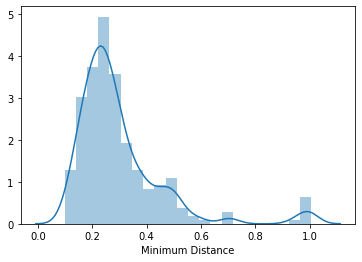

In [181]:
sns.distplot(neighborhood_priority['Minimum Distance'], hist=True)

This histogram indicates a skewed distribution with a few high outliers, suggesting that there is some distinction among neighborhoods, so prioritizing neighborhoods by those with low feature vector distance to the nearest cluster center may be reasonable.

Let's take a look at the top venues in the neighborhoods recommended as most similar to cluster centers to see if we can identify some features that are good indicators of a desirable target neighborhood.

In [185]:
nfhoods_venues_sorted[nfhoods_venues_sorted['Neighborhood'].isin(neighborhood_priority.head(10)['Neighborhood'])]

Cluster Labels        Neighborhood 1st Most Common Venue  \
6                 1             Astoria                   Bar   
35                1    Brooklyn Heights         Deli / Bodega   
81                1        East Village                   Bar   
97                1            Flatiron    Italian Restaurant   
113               1             Gowanus    Italian Restaurant   
114               1            Gramercy                   Bar   
137               1       Hunters Point                  Café   
218               1    Prospect Heights                   Bar   
255               1          South Side           Pizza Place   
284               1  Washington Heights                  Café   

         2nd Most Common Venue   3rd Most Common Venue 4th Most Common Venue  \
6    Middle Eastern Restaurant           Deli / Bodega     Indian Restaurant   
35                 Yoga Studio          Cosmetics Shop           Pizza Place   
81                 Pizza Place      Salon / Barbershop              Wine Bar   
97        Gym / Fitness Center     American Restaurant                   Spa   
113                        Bar  Furniture / Home Store           Yoga Studio   
114         Italian Restaurant             Pizza Place            Bagel Shop   
137         Italian Restaurant     Japanese Restaurant   American Restaurant   
218         Mexican Restaurant            Cocktail Bar             Wine Shop   
255                        Bar             Coffee Shop   American Restaurant   
284                     Bakery           Grocery Store     Mobile Phone Shop   

       5th Most Common Venue 6th Most Common Venue     7th Most Common Venue  \
6                 Food Truck      Greek Restaurant  Mediterranean Restaurant   
35        Italian Restaurant                   Gym                      Park   
81            Ice Cream Shop           Coffee Shop        Italian Restaurant   
97   New American Restaurant   Japanese Restaurant                 Wine Shop   
113     Gym / Fitness Center            Playground             Deli / Bodega   
114                Wine Shop    Mexican Restaurant       American Restaurant   
137              Coffee Shop         Deli / Bodega            Scenic Lookout   
218          Thai Restaurant                Bakery               Coffee Shop   
255                 Wine Bar           Yoga Studio        Mexican Restaurant   
284       Spanish Restaurant           Pizza Place                      Bank   

      8th Most Common Venue     9th Most Common Venue  \
6        Seafood Restaurant                Hookah Bar   
35              Coffee Shop                     Diner   
81        Korean Restaurant        Mexican Restaurant   
97   Furniture / Home Store  Mediterranean Restaurant   
113             Coffee Shop               Art Gallery   
114              Playground            Ice Cream Shop   
137               Wine Shop                  Wine Bar   
218                   Diner                Restaurant   
255              Restaurant        Chinese Restaurant   
284      Italian Restaurant        Chinese Restaurant   

              10th Most Common Venue  
6                                Pub  
35                   Thai Restaurant  
81                        Bagel Shop  
97               Sporting Goods Shop  
113               Chinese Restaurant  
114                   Pilates Studio  
137             Gym / Fitness Center  
218  Southern / Soul Food Restaurant  
255              Japanese Restaurant  
284                   Sandwich Place